In [1]:
# Local Module
from modules import process as prc

# Data Science
import pandas
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Display
from IPython.display import display

In [2]:
train_data = pandas.read_csv('../data/training_data.csv', sep=',', header=0)
test_data = pandas.read_csv('../data/testing_data.csv', sep=',', header=0)


X_train = train_data.iloc[:, 0:6]
X_test = test_data.iloc[:, 0:6]

y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

In [3]:
# bernoulli
BernNP = BernoulliNB(binarize = True)
BernNP.fit(X_train, y_train)

y_pred = BernNP.predict(X_test)
print(prc.accuracy_score(y_pred, y_test))

100.0


In [4]:
# Gaussian
gaussNB = GaussianNB()
gaussNB.fit(X_train, y_train)

y_pred = gaussNB.predict(X_test)

print(prc.accuracy_score(y_pred, y_test))

100.0


In [5]:
# ID3
dTree = DecisionTreeClassifier(criterion='entropy')
dTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
#display(plot_tree(dTree, feature_names=X_train.keys().values))

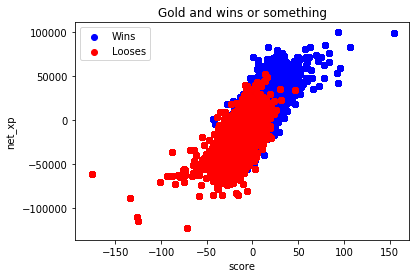

In [7]:
# Get win/loss data
# train
win = train_data[train_data.radiant_win == True]
loss = train_data[train_data.radiant_win == False]
# test
# win = test_data[test_data.radiant_win == True]
# loss = test_data[test_data.radiant_win == False]

data = (win, loss)
colours = ('blue', 'red')
groups = ('Wins', 'Looses')

# Create plot
x_val = 'score'
y_val = 'net_xp'

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for datum, colour, group in zip(data, colours, groups):
    x = datum[x_val]
    y = datum[y_val]
    ax.scatter(x, y, c=colour, label=group)
    
# plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('Gold and wins or something')
plt.legend(loc=2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.show()

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logmodel = LogisticRegression(solver='liblinear')

logmodel.fit(X_train,y_train)

pred = logmodel.predict(X_test) # returns array of predictions [True, True, False, ...]

# print(logmodel.score(X_test, y_test))


# Confusion Matrix
# https://www.listendata.com/2019/07/precision-recall-curve-simplified.html

# True Positive (correctly predicted a win)
true_pos = 0
# False Positive (incorrectly predicted a win)
false_pos = 0
# True Negative (correctly predicted a loss)
true_neg = 0
# False Negative (incorrectly predicted a loss)
false_neg = 0

for i, j in zip(pred, y_test):
    if i == True and j == True:
        true_pos += 1
    elif i == True and j == False:
        false_pos += 1
    elif i == False and j == False:
        true_neg += 1
    elif i == False and j == True:
        false_neg += 1
    else:
        print('Prediction mistake?')
    
# Precision = TP / (TP+FP) = Correctly guessed positive
precision = true_pos / (true_pos + false_pos)
# Recall = TP / (TP+FN) = Proportion of losses predicted as losses
recall = true_pos / (true_pos + false_neg)
    
print('True positive: {}'.format(true_pos))
print('False positive: {}'.format(false_pos))
print('True negative: {}'.format(true_neg))
print('False negative: {}'.format(false_neg))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))

# TODO
# -Larger test sample size
# -Make a table for the confusion matrix


True positive: 60
False positive: 0
True negative: 40
False negative: 0
Precision: 1.0
Recall: 1.0


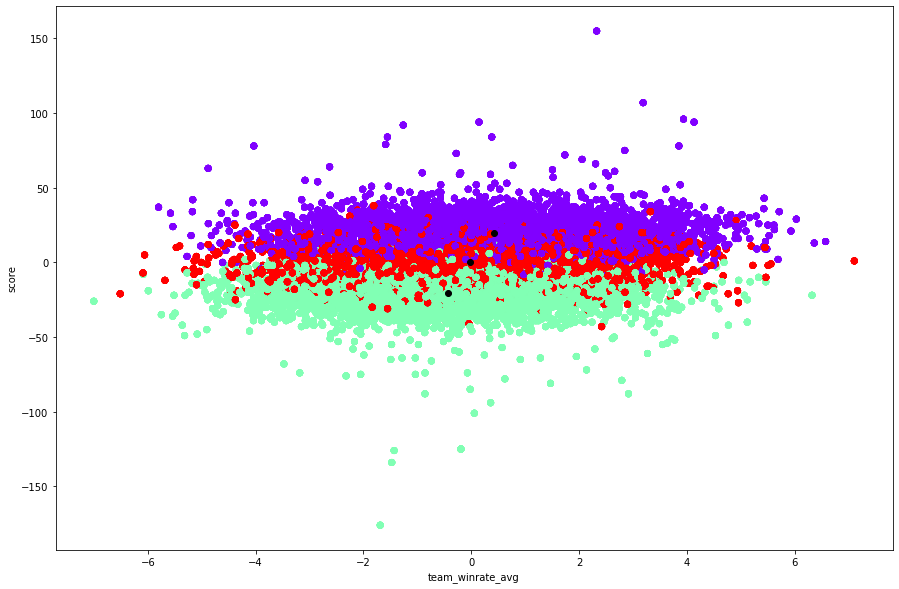

In [10]:
# data = genfromtxt('../data/training_data.csv', delimiter=',', names=True, dtype=None)
from sklearn.cluster import KMeans

X = X_train.to_numpy()

kmeans = KMeans(n_clusters=3).fit(X)
# Columns in the dataset
# net_worth, net_xp, team_winrate_avg, score, net_barracks, duration, radiant_win
columnA = 2
columnB = 3

col_names = X_train.columns.values
colA_name = col_names[columnA]
colB_name = col_names[columnB]

prediction = kmeans.predict(X_test) # predict to which cluster each row in X_test belongs. Neat!
# print(prediction)

plt.xlabel(colA_name)
plt.ylabel(colB_name)

plt.scatter(X[:,columnA],X[:,columnB], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,columnA] ,kmeans.cluster_centers_[:,columnB], color='black')

(109596, 6)
(109596, 1)


ValueError: Found input variables with inconsistent numbers of samples: [109596, 109596, 100]

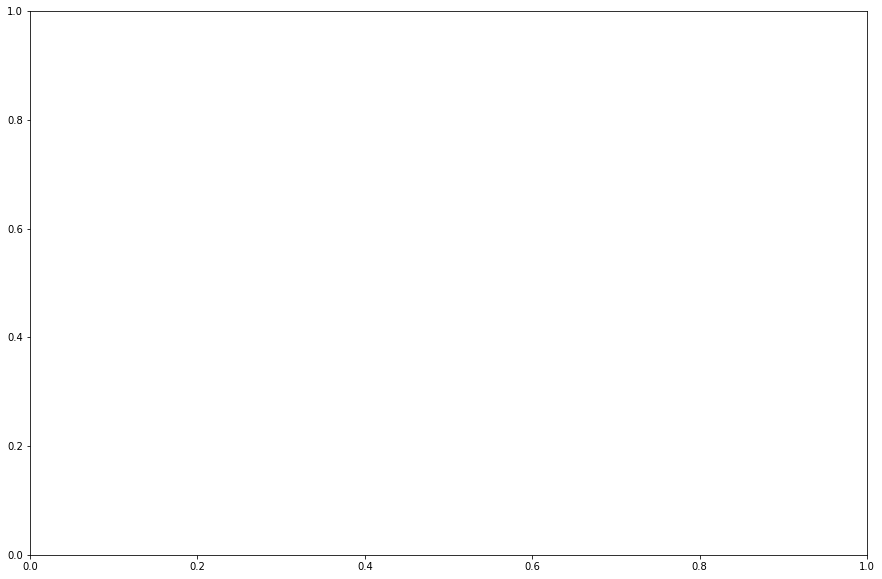

In [11]:
# k fold cross validation:
# https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
# use a limited sample in order to estimate how the model is expected 
# to perform in general when used to make predictions on data not used 
# during the training of the model
from sklearn.model_selection import StratifiedKFold

y = y_train.to_numpy()
y = y.reshape((X.shape[0], 1))

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    return ax



print(X.shape)
print(y.shape)

groups = np.hstack([[ii] * 10 for ii in range(10)])
fig, ax = plt.subplots()
skfold = StratifiedKFold(n_splits=10)


plot_cv_indices(skfold, X, y, groups, ax, 10)
# for train_index, test_index in skfold.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)



In [ ]:
# New prediction idea:
# Given player stats, predict their team